<a href="https://colab.research.google.com/github/vsevolod-BR/prictice/blob/main/random_forest_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
test_targets = pd.read_csv('gender_submission.csv')
test_data = pd.read_csv('test.csv')
combined_data = pd.merge(test_targets, test_data, on = 'PassengerId', how = 'inner')
combined_data.head()

In [ ]:
train_data = pd.read_csv('train.csv')
train_data.head()

In [15]:
data_union = pd.concat([train_data, combined_data], ignore_index=True)
data_union.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
data = pd.DataFrame(data_union)

In [48]:
categorical_features = []
numerical_features = []
data.isna().mean(axis=0)

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.200917
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000764


In [49]:
numerical_features.append('Pclass')
categorical_features.append('Sex')
data['Age'] = data['Age'].fillna(data['Age'].mean())
numerical_features.append('Age') #добавление по одному стобцу через append
numerical_features.extend(['SibSp', 'Parch', 'Fare']) #добавление нескольких признаков через extend
categorical_features.append('Embarked')

In [50]:
number_of_categorical = sum([data[field].nunique(dropna=False) for field in categorical_features])
number_of_categorical

6

In [51]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(data[categorical_features])
categories = []
for i, feature in enumerate(categorical_features):
  categories.extend([f'{feature}: {value}' for value in encoder.categories_[i]])
data.loc[:, categories] = encoder.transform(data[categorical_features]).toarray().astype(int)

In [52]:
features = numerical_features + categories
X = data[features]
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
np.round(y_train.value_counts() / y_train.shape[0] * 100, 2)
np.round(y_test.value_counts() / y_test.shape[0] * 100, 2)

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

In [59]:
def get_metrics(model):
    results = []
    y_pred = model.predict_proba(X_train)
    roc_auc = roc_auc_score(y_train, y_pred[:, 1])
    acc = accuracy_score(y_train, y_pred.argmax(axis=1))
    f1 = f1_score(y_train, y_pred.argmax(axis=1))
    results.append(['Train', roc_auc, acc, f1])
    y_pred = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred[:, 1])
    acc = accuracy_score(y_test, y_pred.argmax(axis=1))
    f1 = f1_score(y_test, y_pred.argmax(axis=1))
    results.append(['Test', roc_auc, acc, f1])
    return pd.DataFrame(columns=['Group', 'ROC-AUC', 'Accuracy', 'F1'], data=results)

In [60]:
get_metrics(tree)

,Group,ROC-AUC,Accuracy,F1
0,Train,0.999265,0.982533,0.976540
1,Test,0.807929,0.819338,0.757679


In [ ]:
grid = {'max_depth': [1, 2, 3, 5, 10, None],
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [1, 5, 10, 50],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]}
search = GridSearchCV(tree, grid)
search.fit(X_train, y_train)

In [62]:
tree = DecisionTreeClassifier(**search.best_params_,)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [63]:
get_metrics(tree)

,Group,ROC-AUC,Accuracy,F1
0,Train,0.925837,0.879913,0.837758
1,Test,0.886900,0.849873,0.783883


In [64]:
pd.DataFrame(data={'feature': features,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending=False).iloc[:10]

,feature,importance
6,Sex: male,0.783286
0,Pclass,0.081856
4,Fare,0.076882
1,Age,0.049257
8,Embarked: Q,0.005428
7,Embarked: C,0.001933
2,SibSp,0.000977
3,Parch,0.000380
5,Sex: female,0.000000
9,Embarked: S,0.000000


[Text(0.5, 0.8333333333333334, 'Sex: female <= 0.5\ngini = 0.47\nsamples = 100.0%\nvalue = [0.622, 0.378]'),
 Text(0.25, 0.5, 'Age <= 5.0\ngini = 0.215\nsamples = 63.3%\nvalue = [0.878, 0.122]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.48\nsamples = 1.6%\nvalue = [0.4, 0.6]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.195\nsamples = 61.7%\nvalue = [0.89, 0.11]'),
 Text(0.75, 0.5, 'Pclass <= 2.5\ngini = 0.297\nsamples = 36.7%\nvalue = [0.182, 0.818]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.063\nsamples = 20.0%\nvalue = [0.033, 0.967]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.461\nsamples = 16.7%\nvalue = [0.359, 0.641]')]

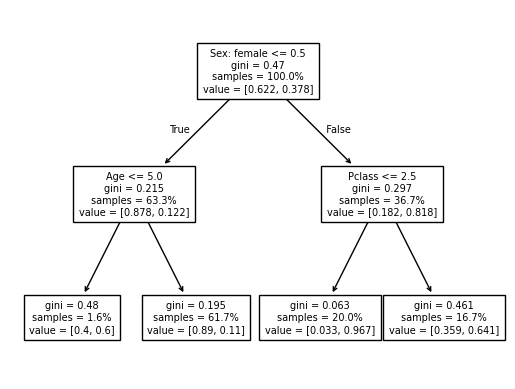

In [65]:
from sklearn.tree import plot_tree


tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)
plot_tree(tree, feature_names=features, fontsize=7, proportion=True)